# Bisender  Multiple Access Channel Nonlocality and Capacity

This notebook explores the capacity and of nonlocal correlations found for quantum bisender multiple access channels where each sender can use one qubit (or bit) of communication.

In [1]:
from context import QNetOptimizer as QNopt
from pennylane import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

In [2]:
mac_bound_inequalities = [
    (np.array([[0,0,0,0,1,0,1,0,0],[1,1,0,1,0,0,0,0,0]]), 4),
    (np.array([[0,0,1,0,1,0,0,0,0],[1,1,0,1,0,0,0,0,0]]), 4),
    (np.array([[0,0,0,0,0,1,1,0,0],[1,1,0,1,0,0,0,1,0]]), 5),
    (np.array([[0,0,0,0,1,0,0,0,1],[1,1,0,1,0,1,0,0,0]]), 5),
    (np.array([[0,0,1,0,1,0,1,0,0],[2,1,0,1,0,1,0,1,0]]), 7),
    (np.array([[0,0,1,0,1,0,1,0,0],[2,2,0,1,0,0,0,1,0]]), 7),
    (np.array([[0,0,1,0,1,0,1,0,0],[2,1,0,2,0,1,0,0,0]]), 7),
    (np.array([[0,0,0,0,1,1,1,0,1],[1,1,0,1,0,0,0,1,0]]), 6),
    (np.array([[0,0,0,0,1,1,2,0,0],[2,2,0,1,0,0,0,1,0]]), 8),
    (np.array([[0,0,0,0,2,0,1,0,1],[2,2,0,1,0,1,0,0,0]]), 8),
    (np.array([[0,0,1,0,2,0,0,0,1],[2,1,0,2,0,1,0,0,0]]), 8),
    (np.array([[0,0,1,0,2,0,0,0,1],[2,1,0,2,0,0,0,1,0]]), 8),
    (np.array([[0,0,1,0,1,0,2,0,0],[2,1,0,0,0,1,0,2,0]]), 8),
    (np.array([[0,0,1,0,2,0,1,0,1],[3,2,0,2,0,1,0,0,0]]), 10),
    (np.array([[0,0,1,0,2,0,1,0,1],[3,2,0,2,0,0,0,1,0]]), 10),
    (np.array([[0,0,2,0,1,0,2,0,0],[3,1,0,1,0,2,0,2,0]]), 11),
    (np.array([[0,0,2,0,2,0,2,0,0],[3,1,0,1,0,3,0,3,1]]), 14),
    (np.array([[0,0,2,0,3,0,2,0,1],[5,3,0,3,0,1,0,1,0]]), 16),
    (np.array([[0,0,2,1,2,0,5,0,1],[4,2,0,0,0,1,0,4,0]]), 17),
]

In [68]:
def priors_scan_range(num_steps):
    eps = 1e-10
    x1_range = np.arange(0,1+eps,1/num_steps)

    priors = []
    for x1 in x1_range:
        x2_range = np.arange(0,1-x1+eps,1/num_steps)
        for x2 in x2_range:
            priors.append(np.array([x1,x2,1-x1-x2]))
        
    return priors

def plot_rate_region(rate_tuple):
    r1, r2, r_sum = rate_tuple
    
    
    r1_vals = [0,0,r_sum-r2,r1,r1,0]
    r2_vals = [0,r2,r2,r_sum-r1,0,0]
    
    plt.plot(r1_vals, r2_vals,"b-",label="Quantum")
    plt.plot([0,0,1,0],[0,1,0,0],"r--",label="Classical")
    plt.legend()
    plt.title("Multiple Access Channel Rate Regions")
    plt.xlabel("Rate 1")
    plt.ylabel("Rate 2")
    plt.show()
    
def sum_rate_cost(network_ansatz,priors_x,priors_y):
    behavior_fn = QNopt.network_behavior_fn(network_ansatz)
    
    def cost(scenario_settings):
        mac_behavior = behavior_fn(scenario_settings)
        rate_tuple = QNopt.bisender_mac_mutual_info(mac_behavior,priors_x,priors_y)
        
        return -(rate_tuple[2])
        
    return cost


In [66]:
arb_prep_nodes = [
    QNopt.PrepareNode(3, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.PrepareNode(3, [1], qml.templates.subroutines.ArbitraryUnitary, 3)
]
arb_meas_nodes = [
    QNopt.MeasureNode(1, 2, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]
arb_mac_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, arb_meas_nodes)

entanglement_prep_nodes = [
    QNopt.PrepareNode(1, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]
local_arb_meas_nodes = [
    QNopt.MeasureNode(3, 2, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.MeasureNode(3, 2, [1], qml.templates.subroutines.ArbitraryUnitary, 3),
]

def local_arb_meas_circuit(settings, wires):
    qml.templates.subroutines.ArbitraryUnitary(settings[0:3],wires=[wires[0]])
    qml.templates.subroutines.ArbitraryUnitary(settings[3:6],wires=[wires[1]])

local_meas_node = [
    QNopt.MeasureNode(1,2,[0,1],local_arb_meas_circuit,6)
]

ea_mac_ansatz = QNopt.NetworkAnsatz(entanglement_prep_nodes, local_arb_meas_nodes)
local_mac_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, local_meas_node)

In [71]:
%%time

local_settings = local_mac_ansatz.rand_scenario_settings()

local_cost = QNopt.linear_probs_cost(local_mac_ansatz, mac_bound_inequalities[18][0])

local_opt_dict = QNopt.gradient_descent(local_cost, local_settings, step_size=0.1, num_steps=75, sample_width=25)




iteration :  0 , score :  11.939916513212625
iteration :  25 , score :  16.97629485722135
iteration :  50 , score :  16.994865754597043
CPU times: user 7.01 s, sys: 38.7 ms, total: 7.04 s
Wall time: 7.04 s


16.9976949455118
id :  52
rate tuple :  (0.9668352738760557, 0.7184122874402252, 0.985598762476755)
priors tuple :  (tensor([0. , 0.4, 0.6], requires_grad=True), tensor([0.2, 0.8, 0. ], requires_grad=True))


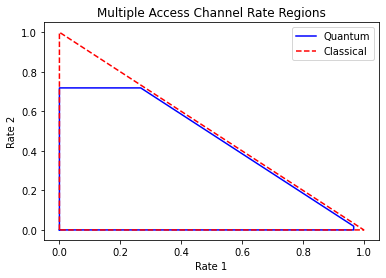

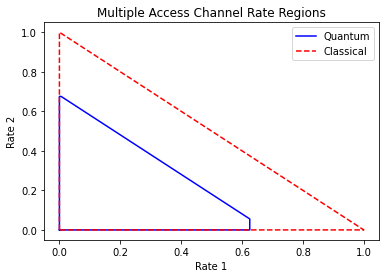

In [73]:
local_mac_behavior = QNopt.network_behavior_fn(local_mac_ansatz)
local_opt_behavior4 = local_mac_behavior(local_opt_dict["opt_settings"])

cg_map = np.array([[1,0,0,1],[0,1,1,0]])

local_opt_behavior = cg_map @ local_opt_behavior4


print(np.sum(np.sum(local_opt_behavior * mac_bound_inequalities[18][0])))

local_rates = []
priors = []
for priors_x in priors_scan_range(5):
    for priors_y in priors_scan_range(5):
        priors.append((priors_x, priors_y))
        local_rates.append(QNopt.bisender_mac_mutual_info(local_opt_behavior, priors_x, priors_y))
        
local_rate_sums = [sum(rate_set) for rate_set in local_rates]
max_local_rate_sum = max(local_rate_sums)
max_local_rate_id = local_rate_sums.index(max_local_rate_sum)
max_local_rate_tuple = local_rates[max_local_rate_id]

print("id : ", max_local_rate_id)
print("rate tuple : ", max_local_rate_tuple)
print("priors tuple : ", priors[max_local_rate_id])
# print(np.sum(np.sum(mac_bound_inequalities[18][0]*)))
plot_rate_region(max_local_rate_tuple)

uniform_rates = QNopt.bisender_mac_mutual_info(local_opt_behavior, np.ones(3)/3, np.ones(3)/3)
plot_rate_region(uniform_rates)


[[0 0 0 0 1 0 1 0 0]
 [1 1 0 1 0 0 0 0 0]]
id :  3148
rate tuple :  (1.0000000000000009, 1.0000000000000009, 1.0000000000000004)
priors tuple :  (tensor([0.5, 0.2, 0.3], requires_grad=True), tensor([0.5, 0.1, 0.4], requires_grad=True))


/Users/brian/opt/anaconda3/envs/pennylane-nonlocality-dev/lib/python3.8/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in log2
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


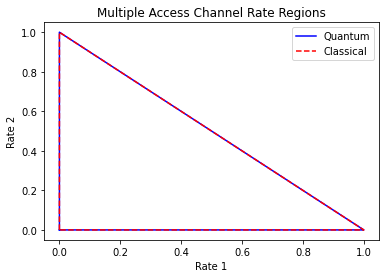

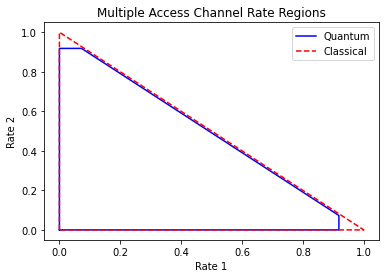

In [69]:
print(mac_bound_inequalities[0][0])
behavior = np.array([[1,0,0,0,1,1,0,1,1],[0,1,1,1,0,0,1,0,0]])

local_rates = []
priors = []
for priors_x in priors_scan_range(10):
    for priors_y in priors_scan_range(10):
        priors.append((priors_x, priors_y))
        local_rates.append(QNopt.bisender_mac_mutual_info(behavior, priors_x, priors_y))
        
local_rate_sums = [sum(rate_set) for rate_set in local_rates]
max_local_rate_sum = max(local_rate_sums)
max_local_rate_id = local_rate_sums.index(max_local_rate_sum)
max_local_rate_tuple = local_rates[max_local_rate_id]

print("id : ", max_local_rate_id)
print("rate tuple : ", max_local_rate_tuple)
print("priors tuple : ", priors[max_local_rate_id])
# print(np.sum(np.sum(mac_bound_inequalities[18][0]*)))
plot_rate_region(max_local_rate_tuple)

uniform_rates = QNopt.bisender_mac_mutual_info(behavior, np.ones(3)/3, np.ones(3)/3)
plot_rate_region(uniform_rates)

16.0
[[0.  1.  0.5 1.  0.  0.5 1.  0.  0.5]
 [1.  0.  0.5 0.  1.  0.5 0.  1.  0.5]]
id :  3218
rate tuple :  (1.0000000000000004, 1.0000000000000004, 1.0000000000000004)
priors tuple :  (tensor([0.5, 0.3, 0.2], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))


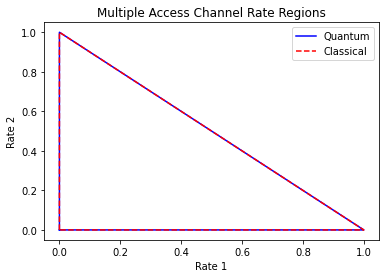

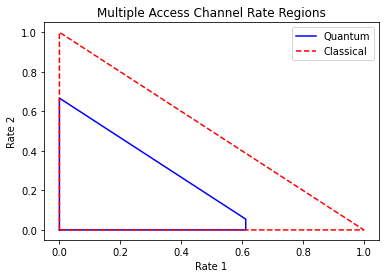

In [70]:
behavior1 = np.array([[0,1,1,1,0,0,1,0,0],[1,0,0,0,1,1,0,1,1]])
behavior2 = np.array([[0,1,0,1,0,1,1,0,1],[1,0,1,0,1,0,0,1,0]])


behavior12 = (behavior1 + behavior2)/2

print(np.sum(np.sum(mac_bound_inequalities[18][0]*behavior12)))

print(behavior12)

local_rates = []
priors = []
for priors_x in priors_scan_range(10):
    for priors_y in priors_scan_range(10):
        priors.append((priors_x, priors_y))
        local_rates.append(QNopt.bisender_mac_mutual_info(behavior12, priors_x, priors_y))
        
local_rate_sums = [np.sum(rate_set) for rate_set in local_rates]
max_local_rate_sum = max(local_rate_sums)
max_local_rate_id = local_rate_sums.index(max_local_rate_sum)
max_local_rate_tuple = local_rates[max_local_rate_id]

print("id : ", max_local_rate_id)
print("rate tuple : ", max_local_rate_tuple)
print("priors tuple : ", priors[max_local_rate_id])
# print(np.sum(np.sum(mac_bound_inequalities[18][0]*)))
plot_rate_region(max_local_rate_tuple)

uniform_rates = QNopt.bisender_mac_mutual_info(behavior12, np.ones(3)/3, np.ones(3)/3)

plot_rate_region(uniform_rates)

In [57]:
arb_settings = arb_mac_ansatz.rand_scenario_settings()
arb_cost = QNopt.linear_probs_cost(arb_mac_ansatz, mac_bound_inequalities[18][0])
arb_opt_dict = QNopt.gradient_descent(arb_cost, arb_settings, step_size=0.1, num_steps=150, sample_width=25)


iteration :  0 , score :  10.374938357496355
iteration :  25 , score :  17.306159163687717
iteration :  50 , score :  17.39981712085522
iteration :  75 , score :  17.400490041441113
iteration :  100 , score :  17.400594469846673
iteration :  125 , score :  17.40061311242468


[[3.07544488e-01 3.06708712e-01 3.07579567e-01 1.48806937e-01
  9.99912272e-01 1.48867349e-01 9.75799787e-01 5.64410647e-02
  9.75807554e-01]
 [6.92455512e-01 6.93291288e-01 6.92420433e-01 8.51193063e-01
  8.77275559e-05 8.51132651e-01 2.42002131e-02 9.43558935e-01
  2.41924459e-02]]
id :  49
rate tuple :  (0.7779262017575337, 0.5264282928667829, 0.7875544177236975)
priors tuple :  (tensor([0. , 0.6, 0.4], requires_grad=True), tensor([0. , 0.8, 0.2], requires_grad=True))


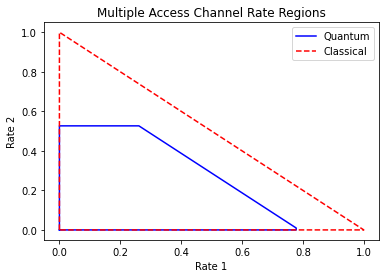

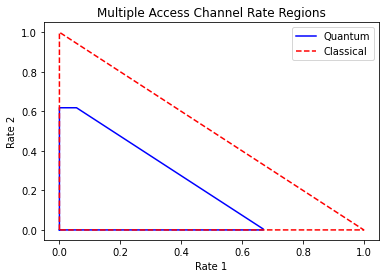

In [47]:
arb_mac_behavior = QNopt.network_behavior_fn(arb_mac_ansatz)
arb_opt_behavior4 = arb_mac_behavior(arb_opt_dict["opt_settings"])

arb_opt_behavior = cg_map @ arb_opt_behavior4

print(arb_opt_behavior)

arb_rates = []
priors = []
for priors_x in priors_scan_range(5):
    for priors_y in priors_scan_range(5):
        priors.append((priors_x, priors_y))
        arb_rates.append(QNopt.bisender_mac_mutual_info(arb_opt_behavior, priors_x, priors_y))
        
arb_rate_sums = [rate_set[2] for rate_set in arb_rates]
max_arb_rate_sum = max(arb_rate_sums)
max_arb_rate_id = arb_rate_sums.index(max_arb_rate_sum)
max_arb_rate_tuple = arb_rates[max_arb_rate_id]

print("id : ", max_arb_rate_id)
print("rate tuple : ", max_arb_rate_tuple)
print("priors tuple : ", priors[max_arb_rate_id])
plot_rate_region(max_arb_rate_tuple)

uniform_rates = QNopt.bisender_mac_mutual_info(local_opt_behavior, np.ones(3)/3, np.ones(3)/3)
plot_rate_region(uniform_rates)


In [78]:
ea_settings = ea_mac_ansatz.rand_scenario_settings()
ea_cost = QNopt.linear_probs_cost(ea_mac_ansatz, mac_bound_inequalities[18][0])
ea_opt_dict = QNopt.gradient_descent(ea_cost, ea_settings, step_size=0.1, num_steps=150, sample_width=25)

iteration :  0 , score :  12.328942398488852
iteration :  25 , score :  18.436015816142937
iteration :  50 , score :  18.955316107548043
iteration :  75 , score :  19.055890181217915
iteration :  100 , score :  19.061971949246587
iteration :  125 , score :  19.0623206336893


id :  1918
rate tuple :  (0.5107892771473952, 0.7522436392280194, 0.7876893308406658)


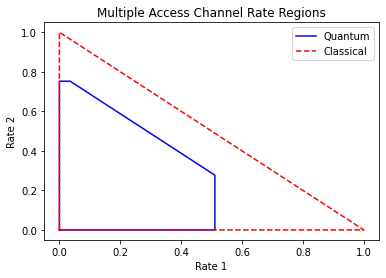

In [79]:
ea_mac_behavior = QNopt.network_behavior_fn(ea_mac_ansatz)
ea_opt_behavior4 = ea_mac_behavior(ea_opt_dict["opt_settings"])

ea_opt_behavior = cg_map @ ea_opt_behavior4

ea_rates = []
for priors_x in priors_scan_range(10):
    for priors_y in priors_scan_range(10):
        ea_rates.append(QNopt.bisender_mac_mutual_info(ea_opt_behavior, priors_x, priors_y))
        
ea_rate_sums = [sum(rate_set) for rate_set in ea_rates]
max_ea_rate_sum = max(ea_rate_sums)
max_ea_rate_id = ea_rate_sums.index(max_ea_rate_sum) 
max_ea_rate_tuple = ea_rates[max_ea_rate_id]

print("id : ", max_ea_rate_id)
print("rate tuple : ", max_ea_rate_tuple)

plot_rate_region(max_ea_rate_tuple)

In [ ]:
arb_rand_settings = arb_mac_ansatz.rand_scenario_settings()
arb_sum_rate_cost = sum_rate_cost(arb_mac_ansatz, np.ones(3)/3, np.ones(3)/3)
QNopt.gradient_descent(arb_sum_rate_cost, arb_rand_settings, step_size=0.1, num_steps=50, sample_width=5)